In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import time
from sklearn.metrics import *
torch.backends.cudnn.deterministic = True

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root = "./data",train = True, download= True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root = "./data",train = False, download= True, transform = transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size)
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


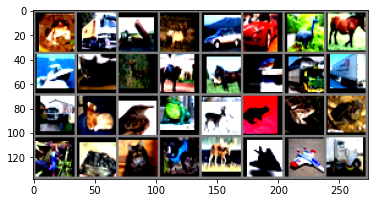

In [4]:
def imshow(img):
    img = img/2 + 0.5 # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size= 3)
        #self.pad1 = nn.ReflectionPad2d(64)
        #self.Batch1 = nn.BatchNorm2d(64)
        self.act1 = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.drop = nn.Dropout(p=0.5)
        

        self.conv2 = nn.Conv2d(64,  128, 3)
        #self.pad2 = nn.ReflectionPad2d(128)
        #self.Batch2 = nn.BatchNorm2d(128)
        self.act2 = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        #self.drop = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(128, 256, 3)
        #self.pad3 = nn.ReflectionPad2d(256)
        #self.Batch3 = nn.BatchNorm2d(256)
        self.act3 = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        #self.drop = nn.Dropout(p=0.5)
        
        self.conv4 = nn.Conv2d(256, 512, 3)
        self.act4 = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.Batchfc1 = nn.BatchNorm2d(512)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(nn.Linear(64 * 4 * 4, 512, bias=True))
        self.fc2 = nn.Sequential(nn.Linear(512, 256))
        self.drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Sequential(nn.Linear(256, 10))
    

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    
    
use_gpu = True

if use_gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: ",device)
    if torch.cuda.is_available():
        net = Net().to(device)
        print("GPU is available")
        print(torch.cuda.device_count())
        print(torch.cuda.get_device_name())
else:
    net = Net()
    print("cpu")

Device:  cuda:0
GPU is available
1
GeForce GTX 1660 Ti


In [6]:
total = 0
print('Trainable parameters:')
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
conv1.weight 	 1728
conv1.bias 	 64
conv2.weight 	 73728
conv2.bias 	 128
conv3.weight 	 294912
conv3.bias 	 256
conv4.weight 	 1179648
conv4.bias 	 512
Batchfc1.weight 	 512
Batchfc1.bias 	 512
fc1.0.weight 	 524288
fc1.0.bias 	 512
fc2.0.weight 	 131072
fc2.0.bias 	 256
fc3.0.weight 	 2560
fc3.0.bias 	 10

Total 	 2210698


In [7]:
#% loss function and optimizer 
error = F.cross_entropy
optimizer = optim.Adam(net.parameters(),lr =0.001)

In [8]:
start = time.time()
for epoch in range(100):   
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs , labels = data
        if use_gpu:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = error(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499: # print every 500 mini batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i+1,running_loss/500))
            running_loss = 0.0
end= time.time()
stopWatch = end-start
print( "Training is done")
print('Total Training Time :',stopWatch)

[1,   500] loss: 1.810
[1,  1000] loss: 1.449
[1,  1500] loss: 1.314
[2,   500] loss: 1.180
[2,  1000] loss: 1.094
[2,  1500] loss: 1.056
[3,   500] loss: 0.992
[3,  1000] loss: 0.935
[3,  1500] loss: 0.929
[4,   500] loss: 0.887
[4,  1000] loss: 0.846
[4,  1500] loss: 0.856
[5,   500] loss: 0.821
[5,  1000] loss: 0.783
[5,  1500] loss: 0.797
[6,   500] loss: 0.765
[6,  1000] loss: 0.740
[6,  1500] loss: 0.744
[7,   500] loss: 0.734
[7,  1000] loss: 0.710
[7,  1500] loss: 0.722
[8,   500] loss: 0.710
[8,  1000] loss: 0.680
[8,  1500] loss: 0.688
[9,   500] loss: 0.677
[9,  1000] loss: 0.653
[9,  1500] loss: 0.661
[10,   500] loss: 0.657
[10,  1000] loss: 0.630
[10,  1500] loss: 0.646
[11,   500] loss: 0.630
[11,  1000] loss: 0.610
[11,  1500] loss: 0.629
[12,   500] loss: 0.613
[12,  1000] loss: 0.594
[12,  1500] loss: 0.614
[13,   500] loss: 0.605
[13,  1000] loss: 0.573
[13,  1500] loss: 0.600
[14,   500] loss: 0.615
[14,  1000] loss: 0.587
[14,  1500] loss: 0.580
[15,   500] loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


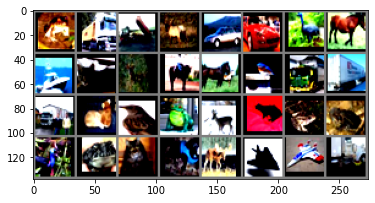

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))  

In [10]:
images, labels = images.to(device), labels.to(device)    
outputs = net(images)   
_, predicted = torch.max(outputs,1)
print("predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(10)))
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy of the network on the 10000 test images: %d %%" % (100*correct/total))    

predicted:   frog truck truck  deer   car   car  bird horse  ship   cat
Accuracy of the network on the 10000 test images: 83 %


In [11]:
def test_label_predictions(model, device, test_loader):
    net.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(net, device, testloader)
print('F1 score: %f' % f1_score(actuals, predictions, average='weighted'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

F1 score: 0.838813
Accuracy score: 0.838700


[[895  10  26  12   6   6   2   7  30   6]
 [ 15 902   2   2   0   3   6   5  14  51]
 [ 35   0 777  36  32  51  42  15   4   8]
 [ 22   3  42 660  21 178  35  13  11  15]
 [  9   0  51  32 797  41  37  25   6   2]
 [  8   1  21  84  16 842   6  20   0   2]
 [  7   1  23  44   8  21 893   0   2   1]
 [ 15   2  22  13  25  58   8 850   2   5]
 [ 54  10   9   6   1   2   6   3 888  21]
 [ 35  38   5   5   0   3   5   9  17 883]]


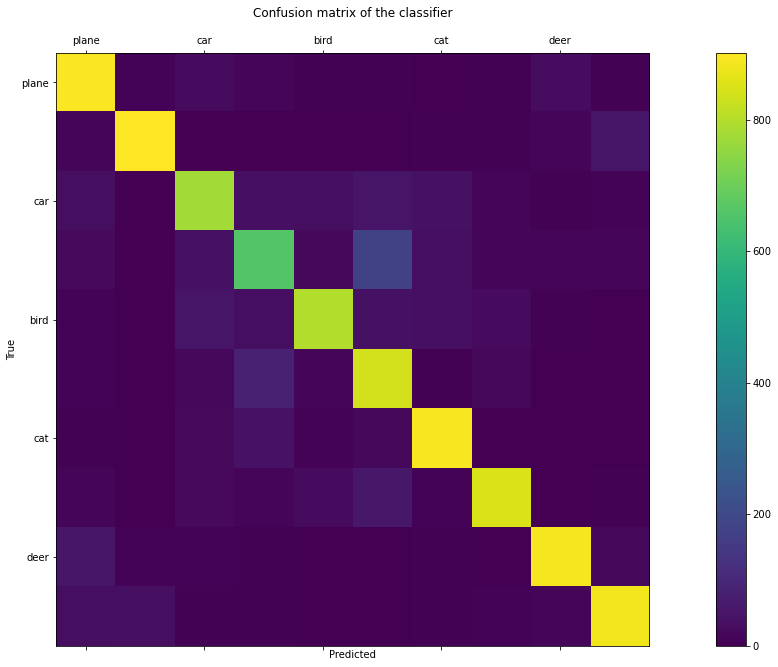

In [12]:
cm = confusion_matrix(actuals, predictions)
print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
print(classification_report(actuals, predictions, target_names=classes, digits=10))

              precision    recall  f1-score   support

       plane  0.8173515982 0.8950000000 0.8544152745      1000
         car  0.9327817994 0.9020000000 0.9171326894      1000
        bird  0.7944785276 0.7770000000 0.7856420627      1000
         cat  0.7382550336 0.6600000000 0.6969376980      1000
        deer  0.8796909492 0.7970000000 0.8363064008      1000
         dog  0.6987551867 0.8420000000 0.7637188209      1000
        frog  0.8586538462 0.8930000000 0.8754901961      1000
       horse  0.8975712777 0.8500000000 0.8731381613      1000
        ship  0.9117043121 0.8880000000 0.8996960486      1000
       truck  0.8883299799 0.8830000000 0.8856569709      1000

    accuracy                      0.8387000000     10000
   macro avg  0.8417572511 0.8387000000 0.8388134323     10000
weighted avg  0.8417572511 0.8387000000 0.8388134323     10000

